In [1]:
from imports import *

# Energy baricenter

**Loading image built in the step 4**

In [2]:
image = np.load("/data/vidales/images/image_realistic_4comp.npy")

In [3]:
print(np.shape(image))

(29582, 59, 70, 16)


**Loading TTrees**

In [4]:
file_path = '/data/vidales/opana_tree_combined_v0411_both.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


**Loading variables that are filtered to eliminate events with more than 1 neutrino. We load the variable nuvX to distinguish in which TPC occurs the interaction**

In [5]:
table = pq.read_table('saved_archives/ophit_variables.parquet')
hit_nuvX_f = ak.from_iter(table.column('hit_nuvX_f').to_pylist())
dEpromx_f = ak.from_iter(table.column('dEpromx_f').to_pylist())
dEpromy_f = ak.from_iter(table.column('dEpromy_f').to_pylist())
dEpromz_f = ak.from_iter(table.column('dEpromz_f').to_pylist())
del table

print("nuvX:", hit_nuvX_f)
print("dEpromx:", dEpromx_f)
print("dEpromy:", dEpromy_f)
print("dEpromz:", dEpromz_f)

nuvX: [[-136], [-132], [-118], [65.5], [182], ..., [-202], [127], [-0.505], [35.4]]
dEpromx: [[-142, -999], [-128, -999], [-110, -999], ..., [-2.29, 179], [-77.4, 37]]
dEpromy: [[141, -999], [159, -999], [-131, -999], ..., [...], [172, 159], [3.33, 78.2]]
dEpromz: [[74.8, -999], [187, -999], [15.1, -999], ..., [...], [261, 488], [273, 251]]


**How many values are in TPC 1 and TPC2?**

In [6]:
# Flatten the array
flat_dEpromx_f = ak.flatten(hit_nuvX_f)

# Count positive and negative values
positive_count = ak.sum(flat_dEpromx_f > 0)
negative_count = ak.sum(flat_dEpromx_f < 0)
total_count = len(flat_dEpromx_f)

# Calculate percentages
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

print(f"Positive values (TPC2): {positive_count} ({positive_percentage:.2f}%)")
print(f"Negative values (TPC1): {negative_count} ({negative_percentage:.2f}%)")
print(f"Total values: {total_count}")

Positive values (TPC2): 13380 (45.23%)
Negative values (TPC1): 16202 (54.77%)
Total values: 29582


In [7]:
# Flatten `nuvX` since we're interested in the first value of each subarray only
flattened_hit_nuvX_f = ak.flatten(hit_nuvX_f, axis=1)

# Select first element if nuvX is negative, second element if nuvX is positive
dEpromx_f_unique = ak.where(flattened_hit_nuvX_f < 0, dEpromx_f[:, 0], dEpromx_f[:, 1])
dEpromy_f_unique = ak.where(flattened_hit_nuvX_f < 0, dEpromy_f[:, 0], dEpromy_f[:, 1])
dEpromz_f_unique = ak.where(flattened_hit_nuvX_f < 0, dEpromz_f[:, 0], dEpromz_f[:, 1])

# Print the result
print("Selected elements:", dEpromx_f_unique)
print("Length:", len(dEpromx_f_unique))

Selected elements: [-142, -128, -110, 89.8, 182, 86.5, ..., -84.3, -124, -201, 123, -2.29, 37]
Length: 29582


In [8]:
# Create a boolean mask where dEpromx_f_unique is not -999
mask = dEpromx_f_unique != -999

# Apply the mask to both the image and dEpromx_f_unique to keep only the valid entries
filtered_image = image[mask]
filtered_dEpromx_f_unique = dEpromx_f_unique[mask]
filtered_dEpromy_f_unique = dEpromy_f_unique[mask]
filtered_dEpromz_f_unique = dEpromz_f_unique[mask]
del(image)

In [9]:
print(np.shape(filtered_image))
print(np.shape(filtered_dEpromx_f_unique))

(29417, 59, 70, 16)
[29417]


In [10]:
assert np.shape(filtered_image)[0] == np.shape(filtered_dEpromx_f_unique)[0]
assert np.shape(filtered_image)[0] == np.shape(filtered_dEpromy_f_unique)[0]
assert np.shape(filtered_image)[0] == np.shape(filtered_dEpromz_f_unique)[0]

In [11]:
dEprom = np.column_stack((filtered_dEpromx_f_unique, filtered_dEpromy_f_unique, filtered_dEpromz_f_unique))
dEprom_np = ak.to_numpy(dEprom)
print("Merged dEprom:")
print(dEprom_np)
print(np.shape(dEprom_np))

Merged dEprom:
[[-141.81035117  140.83112553   74.82157564]
 [-128.18496115  158.65734985  187.35995061]
 [-109.6146554  -131.17913959   15.07603944]
 ...
 [ 122.74146747   88.72589418  287.34965045]
 [  -2.2859062   171.68138257  260.6528424 ]
 [  36.9916876    78.19434956  251.45103767]]
(29417, 3)


## Creation of train and test sets

In [12]:
test_size = int(np.floor(0.60*np.shape(dEprom)[0]) )
print(test_size)

17650


In [13]:
x_train, x_test = filtered_image[:-test_size], filtered_image[-test_size:]

In [14]:
y_train, y_test = dEprom_np[:-test_size], dEprom_np[-test_size:]

**Model architecture**

In [15]:
def create_cnn_model(x_train, conv_dim, maxpool_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.BatchNormalization()(input_layer)
    model = layers.Conv2D(128, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(256, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(512, conv_dim, padding='same')(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D(maxpool_dim, padding='same')(model)
    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.2)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.2)(model)
    model = layers.Dense(256, activation='relu')(model)
   
    
    # Output layer
    output_layer = layers.Dense(3, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

In [16]:
model_4compreal = create_cnn_model(x_train, (4,5),(2,2))

In [17]:
dEprom_4compreal, history_dEprom_4compreal = train_and_predict(model_4compreal, x_train, y_train, x_test, y_test, epochs=20, batch_size=32)

Epoch 1/20
368/368 [==============================] - ETA: 0s - loss: 9706.2061 - mse: 9706.2061

2024-11-12 18:32:15.057865: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4665248000 exceeds 10% of free system memory.
2024-11-12 18:32:18.617472: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4665248000 exceeds 10% of free system memory.


368/368 [==============================] - 52s 95ms/step - loss: 9706.2061 - mse: 9706.2061 - val_loss: 24444.0312 - val_mse: 24444.0312
Epoch 2/20
368/368 [==============================] - 25s 68ms/step - loss: 2858.9624 - mse: 2858.9624 - val_loss: 2257.4473 - val_mse: 2257.4473
Epoch 3/20
368/368 [==============================] - 25s 68ms/step - loss: 2347.7793 - mse: 2347.7793 - val_loss: 1695.5505 - val_mse: 1695.5505
Epoch 4/20
368/368 [==============================] - 25s 68ms/step - loss: 2168.5542 - mse: 2168.5542 - val_loss: 1464.4150 - val_mse: 1464.4150
Epoch 5/20
368/368 [==============================] - 24s 66ms/step - loss: 1922.3331 - mse: 1922.3331 - val_loss: 1801.9584 - val_mse: 1801.9584
Epoch 6/20
368/368 [==============================] - 25s 68ms/step - loss: 1936.5684 - mse: 1936.5684 - val_loss: 1367.6345 - val_mse: 1367.6345
Epoch 7/20
368/368 [==============================] - 24s 66ms/step - loss: 1841.7640 - mse: 1841.7640 - val_loss: 1403.7024 - val_ms

2024-11-12 18:41:04.928987: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4665248000 exceeds 10% of free system memory.
2024-11-12 18:41:08.606030: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4665248000 exceeds 10% of free system memory.


/home/vidales/.local/lib/python3.9/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


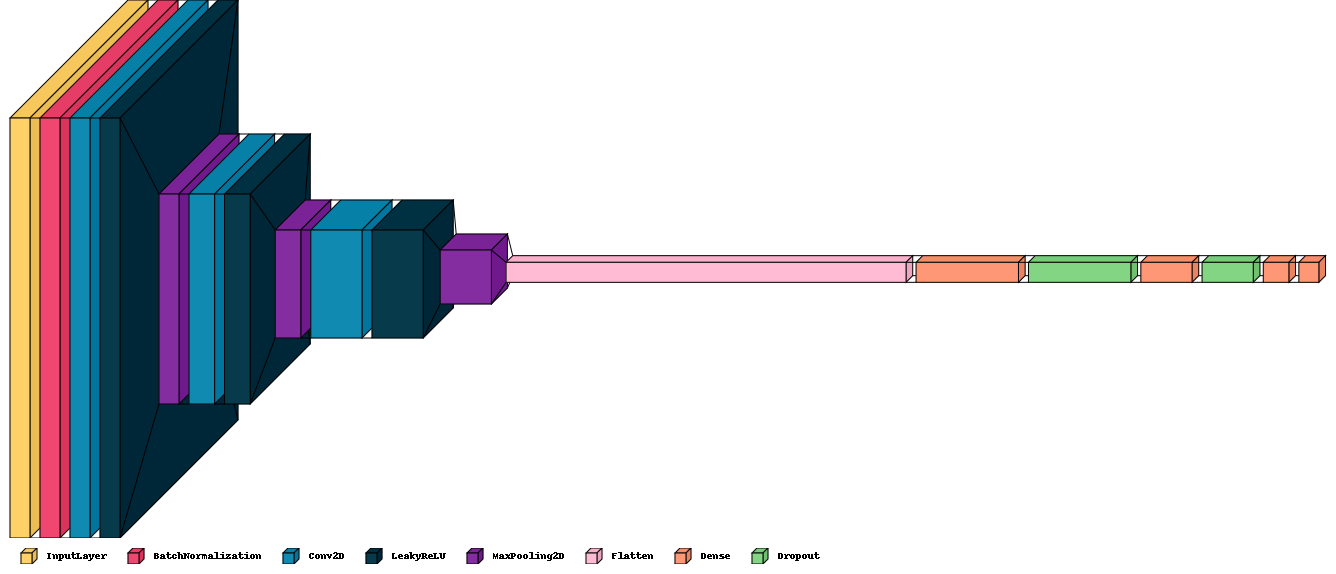

In [18]:
visualkeras.layered_view(model_4compreal, legend=True,scale_xy=6, to_file='output.png')  # font is optional!

In [19]:
print(y_test[0])
print(dEprom_4compreal[0])

[  38.75541385 -119.87030768  421.21796663]
[  46.849876 -118.53991   418.4712  ]


In [20]:
testScoreECM_X = mean_squared_error(y_test[:,0], dEprom_4compreal[:,0])
testScoreECM_Y = mean_squared_error(y_test[:,1], dEprom_4compreal[:,1])
testScoreECM_Z = mean_squared_error(y_test[:,2], dEprom_4compreal[:,2])
print('RECM_X: %.4f' % np.sqrt((testScoreECM_X)))
print('RECM_Y: %.4f' % np.sqrt((testScoreECM_Y)))
print('RECM_Z: %.4f' % np.sqrt((testScoreECM_Z)))

RECM_X: 32.1890
RECM_Y: 29.2459
RECM_Z: 38.6067


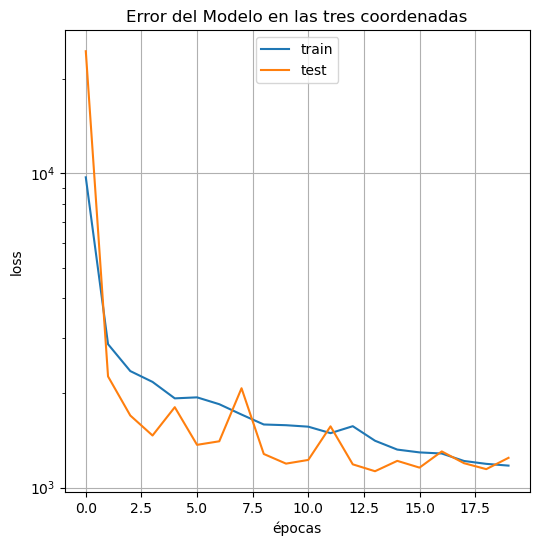

In [21]:
plt.figure(1, figsize=(6,6))
plt.plot(history_dEprom_4compreal.history['mse'])
plt.plot(history_dEprom_4compreal.history['val_mse'])

plt.yscale("log")
plt.title('Error del Modelo en las tres coordenadas')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.grid()
plt.legend(['train', 'test'], loc='upper center')
plt.show()

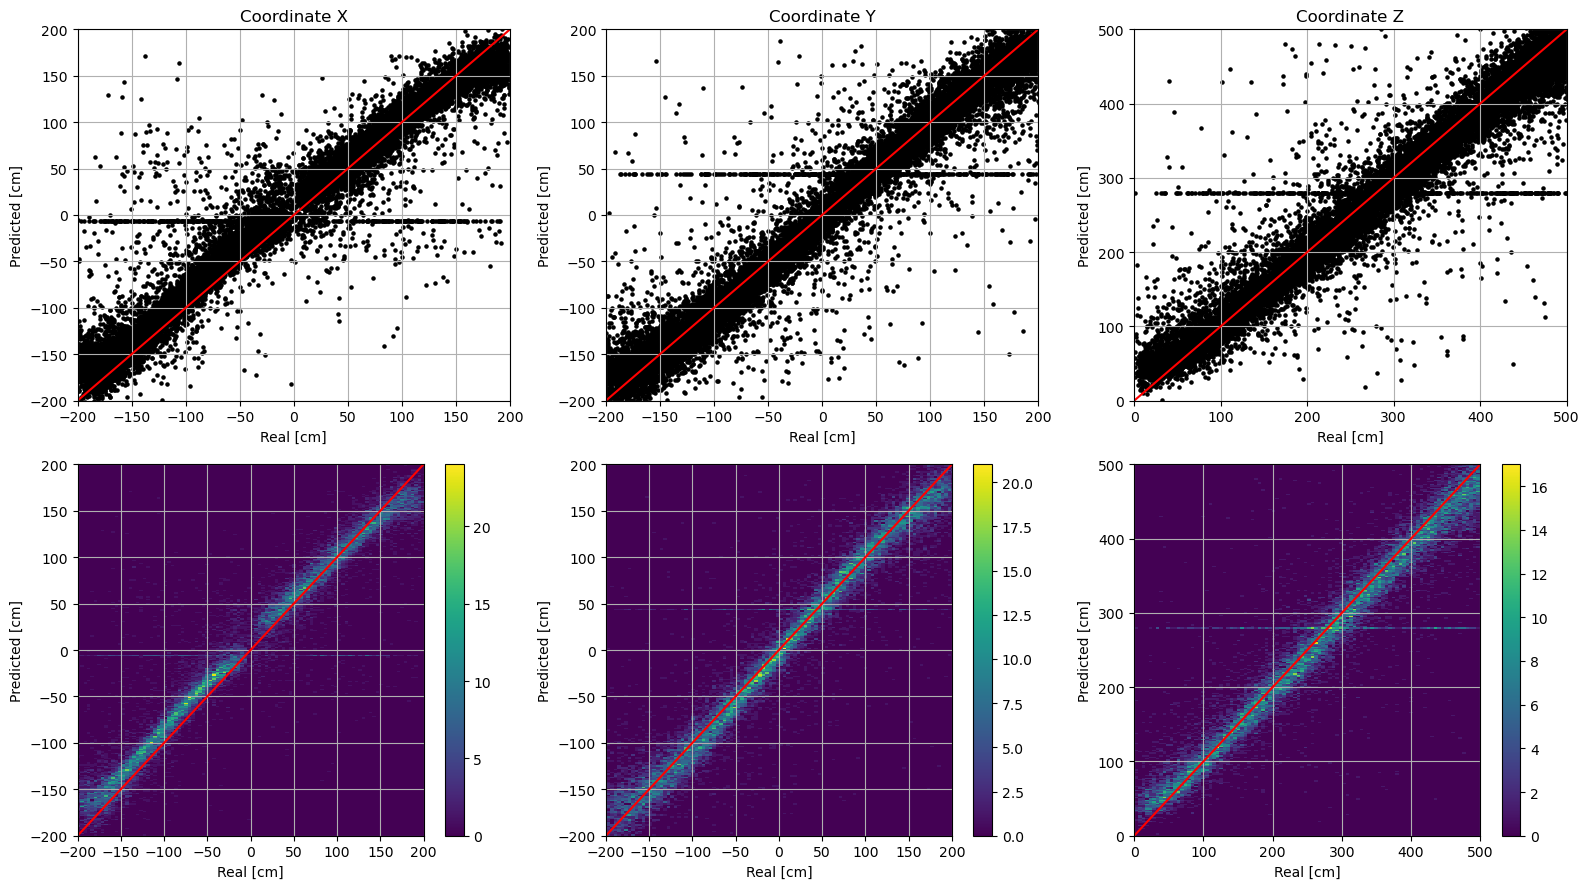

In [22]:
fig, axs = plt.subplots(2,3,figsize=(16,9))

axs[0,0].scatter(y_test[:,0], dEprom_4compreal[:,0], color="black",s=5)
axs[0,0].grid()

axs[0,0].plot([-200,200],[-200,200],color="r")
axs[0,0].title.set_text('Coordinate X')
axs[0,0].set_xlim([-200,200])
axs[0,0].set_ylim([-200,200])
axs[0,0].set_ylabel('Predicted [cm]')
axs[0,0].set_xlabel('Real [cm]')


im1 = axs[1,0].hist2d(y_test[:,0], dEprom_4compreal[:,0].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([-200,200],[-200,200],'r')
axs[1,0].set_xlim([-200,200])
axs[1,0].set_ylim([-200,200])
axs[1,0].set_ylabel('Predicted [cm]')
axs[1,0].set_xlabel('Real [cm]')
axs[1,0].set_facecolor('#440154')



axs[0,1].scatter(y_test[:,1], dEprom_4compreal[:,1], color="black",s=5)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate Y')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')


im2 = axs[1,1].hist2d(y_test[:,1], dEprom_4compreal[:,1].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im2[3], ax=axs[1,1])
axs[1,1].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')


axs[0,2].scatter(y_test[:,2], dEprom_4compreal[:,2], color="black",s=5)
axs[0,2].grid()

axs[0,2].plot([0,500],[0,500],color="r")
axs[0,2].title.set_text('Coordinate Z')
axs[0,2].set_xlim([0,500])
axs[0,2].set_ylim([0,500])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im3 = axs[1,2].hist2d(y_test[:,2], dEprom_4compreal[:,2].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im3[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].set_xlim([0,500])
axs[1,2].set_ylim([0,500])
axs[1,2].plot([0,500],[0,500], 'r')
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')

fig.tight_layout()

plt.savefig('/tmp/CNNx2+4T+N_Recta_S.png', dpi=300)

Adjustement variables
------------------
Media X = 9.549770051966709
Sigma X = -14.283371243220572
------------------
Media Y = -2.944662032919724
Sigma Y = -14.255525769923725
------------------
Media Z = -4.82331291091349
Sigma Z = -19.572297036861578
------------------
Mediana R = 24.898230358802607
Sigma R = 15.155444566227672
------------------


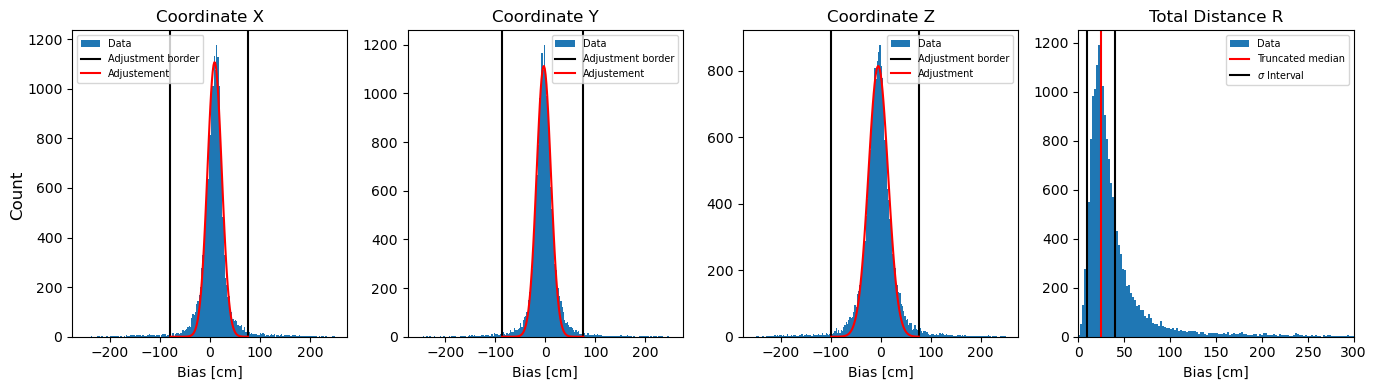

In [23]:
# Adjustement gaussiano de las diferencias entre el pronóstico y el valor real

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Valores de los histogramas
diffX = dEprom_4compreal[:,0].flatten()-y_test[:,0]
diffY = dEprom_4compreal[:,1].flatten()-y_test[:,1]
diffZ = dEprom_4compreal[:,2].flatten()-y_test[:,2]
diffR = np.sqrt(diffX**2+diffY**2+diffZ**2)

fig, axs = plt.subplots(1,4,figsize=(14,4))

# Valores de X
axs[0].title.set_text('Coordinate X')
counts_X, bins_X, patches_X = axs[0].hist(diffX,200,range=[-250,250], label='Data')

step_X = (bins_X[1]-bins_X[0])/2
bin_centers_X = bins_X[:-1]+step_X

ini_X = 68
fin_X = 130
axs[0].axvline(x = bin_centers_X[ini_X], color = 'k', label='Adjustment border')
axs[0].axvline(x = bin_centers_X[fin_X], color = 'k')

popt_X, pcov_X = curve_fit(func, bin_centers_X[ini_X:fin_X+1], counts_X[ini_X:fin_X+1])


ym_X = func(np.linspace(bin_centers_X[ini_X], bin_centers_X[fin_X],100), popt_X[0], popt_X[1], popt_X[2])
axs[0].plot(np.linspace(bin_centers_X[ini_X], bin_centers_X[fin_X],100), ym_X, c='r', label='Adjustement')
axs[0].set_xlabel('Bias [cm]')
axs[0].legend(prop = { "size": 7 })


# Valores de Y
axs[1].title.set_text('Coordinate Y')
counts_Y, bins_Y, patches_Y = axs[1].hist(diffY,200,range=[-250,250], label='Data')

step_Y = (bins_Y[1]-bins_Y[0])/2
bin_centers_Y = bins_Y[:-1]+step_Y

ini_Y = 65
fin_Y = 130
axs[1].axvline(x = bin_centers_Y[ini_Y], color = 'k', label='Adjustment border')
axs[1].axvline(x = bin_centers_Y[fin_Y], color = 'k')

popt_Y, pcov_Y = curve_fit(func, bin_centers_Y[ini_Y:fin_Y+1], counts_Y[ini_Y:fin_Y+1])


ym_Y = func(np.linspace(bin_centers_Y[ini_Y], bin_centers_Y[fin_Y],100), popt_Y[0], popt_Y[1], popt_Y[2])
axs[1].plot(np.linspace(bin_centers_Y[ini_Y], bin_centers_Y[fin_Y],100), ym_Y, c='r', label='Adjustement')
axs[1].set_xlabel('Bias [cm]')
axs[1].legend(prop = { "size": 7 })

# Valores de Z
axs[2].title.set_text('Coordinate Z')
counts_Z, bins_Z, patches_Z = axs[2].hist(diffZ,200,range=[-250,250], label='Data')

step_Z = (bins_Z[1]-bins_Z[0])/2
bin_centers_Z = bins_Z[:-1]+step_Z

ini_Z = 60
fin_Z = 130
axs[2].axvline(x = bin_centers_Z[ini_Z], color = 'k', label='Adjustment border')
axs[2].axvline(x = bin_centers_Z[fin_Z], color = 'k')

popt_Z, pcov_Z = curve_fit(func, bin_centers_Z[ini_Z:fin_Z+1], counts_Z[ini_Z:fin_Z+1])


ym_Z = func(np.linspace(bin_centers_Z[ini_Z], bin_centers_Z[fin_Z],100), popt_Z[0], popt_Z[1], popt_Z[2])
axs[2].plot(np.linspace(bin_centers_Z[ini_Z], bin_centers_Z[fin_Z],100), ym_Z, c='r', label='Adjustment')
axs[2].set_xlabel('Bias [cm]')
axs[2].legend(prop = { "size": 7 })

# Valores de R (semi-definida positiva)
counts_R, bins_R, patches_R = axs[3].hist(diffR,200,range=[0,np.sqrt(3)*250],label='Data')

step_R = (bins_R[1]-bins_R[0])/2
bin_centers_R = bins_R[:-1]+step_R

mediana_R = st.median(diffR)

i = 0
while bins_R[i] < mediana_R:
  bin_mediana = i
  i += 1

porcentaje = 0
j = [1,0]
while porcentaje < 0.682:
  if counts_R[i-j[0]] == counts_R[i+j[1]]:
    j[randint(0, 1)] += 1
  elif counts_R[i-j[0]] > counts_R[i+j[1]]:
    j[0] += 1
  else:
    j[1] += 1
  porcentaje = sum(counts_R[i-j[0]:i+1+j[1]])/sum(counts_R)

intervalo_sigma = bin_centers_R[i+j[1]]-bin_centers_R[i-j[0]]
mediana_R_trunc = (bin_centers_R[i+j[1]]+bin_centers_R[i-j[0]])/2

axs[3].axvline(x = mediana_R_trunc, color = 'r', label='Truncated median')

axs[3].axvline(x = bin_centers_R[i-j[0]], color = 'k', label='$\sigma$ Interval')
axs[3].axvline(x = bin_centers_R[i+j[1]], color = 'k')

axs[3].title.set_text('Total Distance R')
axs[3].set_xlim([0,300])
axs[3].set_xlabel('Bias [cm]')
axs[3].legend(prop = { "size": 7 })


fig.supylabel('Count')
fig.tight_layout()

plt.savefig('/tmp/CNNx2+4T+N_Distrib_S.png', dpi=300)


print('Adjustement variables')
print('------------------')
print('Media X =',popt_X[1])
print('Sigma X =',popt_X[2])
print('------------------')
print('Media Y =',popt_Y[1])
print('Sigma Y =',popt_Y[2])
print('------------------')
print('Media Z =',popt_Z[1])
print('Sigma Z =',popt_Z[2])
print('------------------')
print('Mediana R =',mediana_R_trunc)
print('Sigma R =',intervalo_sigma/2)
print('------------------')

## Visualize intermediate layers

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_intermediate_layers(model, x_train, sample_index=0):
    """
    Visualizes intermediate layer outputs for a specific sample from the training data.
    
    Parameters:
    - model: The trained Keras model.
    - x_train: The training data.
    - sample_index: Index of the sample from x_train to visualize.
    """
    # Get the outputs of all intermediate layers
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = Model(inputs=model.input, outputs=successive_outputs)
    
    # Select a sample image from x_train
    sample_image = x_train[sample_index:sample_index + 1]  # Shape should be (1, height, width, channels)
    
    # Pass the image through the model to get intermediate representations
    successive_feature_maps = visualization_model.predict(sample_image)
    
    # Get layer names for labeling
    layer_names = [layer.name for layer in model.layers[1:]]
    
    # Plot each layer's feature map
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:  # Only consider convolutional layers (ignore dense layers)
            n_features = feature_map.shape[-1]  # Number of filters
            size = feature_map.shape[1]  # Spatial dimensions
            
            # Create a grid for visualizing each filter's feature map
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                
                # Normalize the feature map values for better visualization
                x -= x.mean()
                x /= (x.std() + 1e-5)
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                
                # Resize or pad `x` if it doesn't match the expected dimensions
                if x.shape[1] < size:
                    x = np.pad(x, ((0, 0), (0, size - x.shape[1])), mode='constant')
                elif x.shape[1] > size:
                    x = x[:, :size]
                
                # Put each filter's activation in the display grid
                display_grid[:, i * size : (i + 1) * size] = x
            
            # Display the grid
            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()

# Use the function to visualize intermediate representations of your model
# Assuming x_train is your training data and create_cnn_model has been defined
#model, _ = create_cnn_model(x_train, conv_dim=(3, 3), maxpool_dim=(2, 2))
#visualize_intermediate_layers(model, x_train)


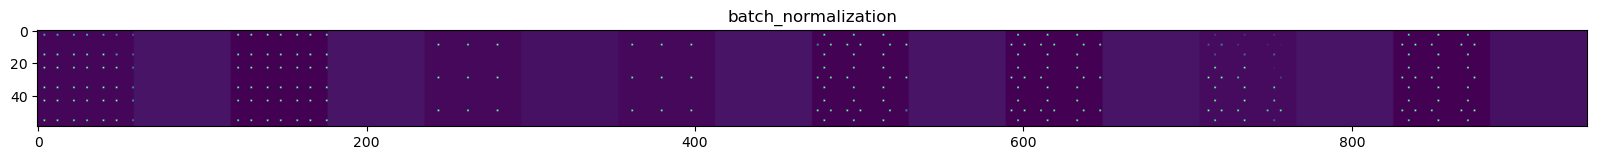

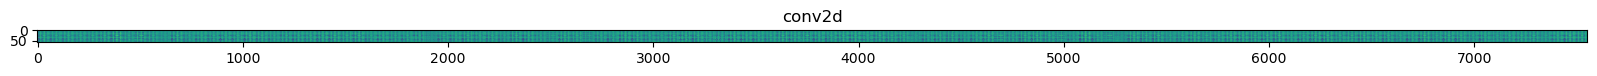

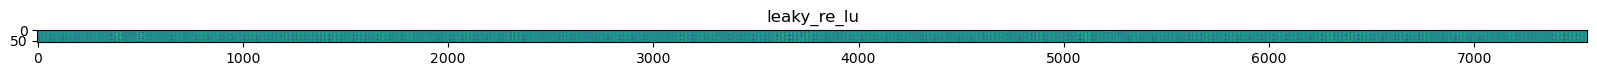

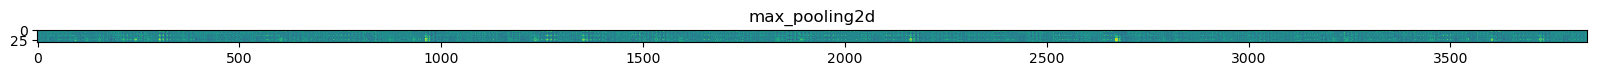

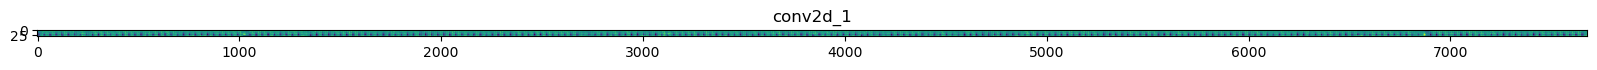

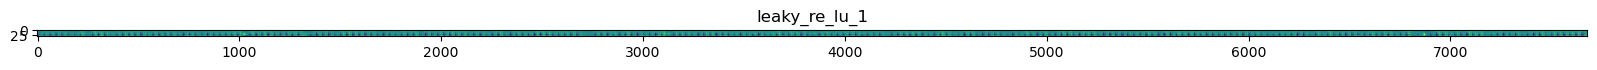

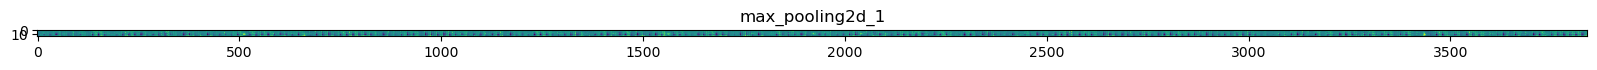

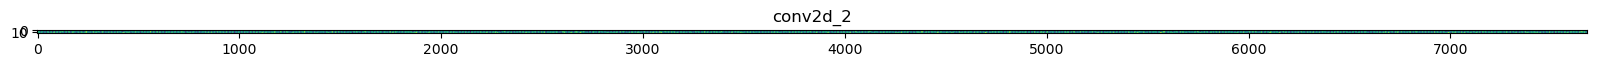

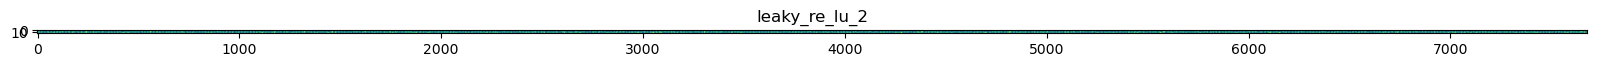

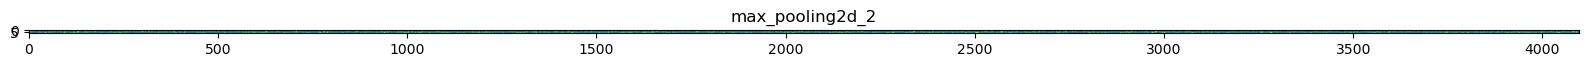

In [25]:
visualize_intermediate_layers(model_4compreal, x_train)